In [1]:
%matplotlib inline

## Import Dependancies ##
import re
import glob
import pandas as pd
import numpy as np
import math
from math import ceil, floor
from sklearn.datasets import load_digits
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure

# opens plotly in browser
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"

#umap
import umap
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10

output_notebook()

from io import BytesIO
from PIL import Image
import base64



'''
#import classes
import Image_Classes as im
from Image_Classes import *
'''



Loading BokehJS ...

'\n#import classes\nimport Image_Classes as im\nfrom Image_Classes import *\n'

In [2]:
class Check_Segmentation():
    '''
    Class which loads coordinates of mito, nuclei or cyto according to labels supplied. 
    If subset is supplied, the same subset must be used for mito, nuclei, cyto.

    :param dir_path: str, path to directory of cell segmentations
    :param mito: boolean
    :param nuclei: boolean
    :param cyto: boolean
    :param subset: list/None, references which cells are to be plotted, examples include "range(1, 3), [1, 2, 10] or None" if no subset required and you want to plot all cells
    
    '''

    def __init__(self, dir_path, mito, nuclei, cyto, subset):
        self.dir_path = dir_path
        self.mito = mito
        self.nuclei = nuclei
        self.cyto = cyto
        self.subset = subset # add as argument either: range(1, 3), [1, 2, 10] or None if no subset required and you want to plot all cells

    def get_coordinates(self):

        '''
        Given organelles (mito, nuclei, cyto) returns a dictionary of their coordinates.

        :return coord_dict: dict, keys represent organelles, values are dataframe of organelles for all cells, headers "x", "y", "z", "label"
        '''

        # initialise dictionary
        coord_dict = {}

        # get mito coordinates for cells in subset
        if self.mito==True:
            
            mito_files = glob.glob(self.dir_path + "/mito.*.csv")

            mi = []

            for filename in mito_files:
                splitter = '{}mito.p_cell_|_coordinates.csv'.format(self.dir_path)
                labels = re.split(splitter, filename)
                df = pd.read_csv(filename, header=0) #index_col=0 - removed
                df["label"] = int(labels[1])
                mi.append(df)

            mito_frame = pd.concat(mi, axis=0)

            coord_dict["mito"] = mito_frame
            
        # get nuclei coordinates for cells in subset
        if self.nuclei==True:
            
            nuclei_files = glob.glob(self.dir_path + "/nucleus.*.csv")

            nu = []

            for filename in nuclei_files:
                splitter = '{}nucleus.p_cell_|_coordinates.csv'.format(self.dir_path)
                labels = re.split(splitter, filename)
                df = pd.read_csv(filename, index_col=0, header=0)
                df["label"] = int(labels[1])
                nu.append(df)

            nuclei_frame = pd.concat(nu, axis=0, ignore_index=True)

            coord_dict["nuclei"] = nuclei_frame
            
        # get cyo coordinates for cells in subset
        if self.cyto==True:
            
            cyto_files = glob.glob(self.dir_path + "/cytoplasm.*.csv")
            
            cy = []

            for filename in cyto_files:
                splitter = '{}cytoplasm.p_cell_|_coordinates.csv'.format(self.dir_path)
                labels = re.split(splitter, filename)
                df = pd.read_csv(filename, header=0)
                df["label"] = int(labels[1])
                cy.append(df)

            cyto_frame = pd.concat(cy, axis=0)

            coord_dict["cyto"] = cyto_frame

        # return dictionary
        return coord_dict
    
    def subset_coordinates(self):

        '''
        Given subset and organelles (mito, nuclei, cyto) returns a dictionary of their coordinates.

        :return coord_dict: dict, keys represent organelles, values are dataframe of organelles for subset of cells, headers "x", "y", "z", "label"
        '''
        
        # get dictionary of all cells
        coord_dict = self.get_coordinates()
        
        #subset by self.subset (the subset list you have supplied)
        if self.subset is not None:
            # iterate through organelle (key) in dictionary
            for key in coord_dict:
                frame = coord_dict[key]
                s_frame = frame.loc[frame['label'].isin(self.subset)]
                coord_dict[key] = s_frame
        
        # subsetted dictionary, keys are organelles, values are dataframe of subset of cells
        return coord_dict

    def flag_clusters(self):
        '''
        TBC
        Return label and organelle name if 3D point cloud is more than 1 distinct cluster
        if this would not be expected e.g. nuclei or cyto
        '''
        
        pass

    
    def plot_organelles_as_scatter(self):
        
        '''
        Returns interactive 3D plot of all organelles specified in subset. 
        Plots every point in point cloud (3D scatter plot).
        If only one organelle is specified: each cell is assigned a different colour.
        If more than 1 organelle is specified: each organelle is assigned a different colour.

        CAUTION: Plotly typically can't handle plotting all organelles in all cells as scatter. 
        I'm working on reducing the number of points per cell to make it more manageable.
        Convex hull works but visualisation isn't very informative. 
        The best option currently is to subset cells. 
        '''
        
        # dictionary
        coord_dict = self.subset_coordinates()

        # initialise figure
        fig = go.Figure()

        color_list = [1, 2, 3]

        # key here represents organelle
        for key,c in zip(coord_dict, color_list):

            trace = go.Scatter3d(
                    x=coord_dict[key]["x"],
                    y=coord_dict[key]["y"],
                    z=coord_dict[key]["z"],
                    mode='markers',
                    marker=dict(
                        size=2,
                        color=c,                # set color to an array/list of desired values, here colour_list
                        colorscale='Turbo',
                        opacity=0.8, 
                    ),
                    name = key
                )
            fig.add_trace(trace)

        # ensures x, y, z axes are on the same scale
        fig.update_layout(scene_aspectmode='data')
        fig.show()
    
    def plot_organelles_as_convex_hull(self):

        '''
        Returns interactive 3D plot of all organelles specified in subset. 
        Plots every organelle as it's convex hull
        If only one organelle is specified: each cell is assigned the same colour.
        If more than 1 organelle is specified: each organelle is assigned a different colour.
        You can change these colours by changing colour_list. 

        CAUTION: Be careful with convex hull. It creates a bounding box around the outmost vertices. 
        High resolution is lost. I'm working on an inbetween but it requires input in a different format so taking a little longer.
        
        '''

        # dictionary
        coord_dict = self.subset_coordinates()

        # initialise figure
        fig = go.Figure()
        color_list = ["red", "blue", "green"]

        # iterate through organelles (keys) and colours 
        for key,c in zip(coord_dict, color_list):

            # subset columns for each organelle
            xyzl = coord_dict[key][["y", "x", "z", "label"]]

            # iterate through organelle for each cell 
            for i in xyzl["label"].unique():
                
                #subset and convert from panda to numpy for convex hull
                xyz_la = xyzl[xyzl["label"]==i]
                xyz = xyz_la[["x", "y", "z"]]
                matrix = xyz.to_numpy()
                
                xc = matrix[ConvexHull(matrix).vertices]
            
                fig.add_trace(go.Mesh3d(x=xc[:, 0], 
                                        y=xc[:, 1], 
                                        z=xc[:, 2], 
                                        color=c, 
                                        opacity=1,
                                        # specifies convex hull
                                        alphahull=0))
        
        fig.update_layout(scene_aspectmode='data')
        fig.show() 

In [3]:
class Slice_Maker(Check_Segmentation):

    def __init__(self, dir_path, mito, nuclei, cyto, subset, image_size):
        Check_Segmentation.__init__(self, dir_path, mito, nuclei, cyto, subset)

        '''
        Class which inherits from Check_Segmentation. 
        Some visualisations require a the point cloud to be loaded as 3D numpy arrays i.e. binary slices

        :param dir_path: str, path to directory of cell segmentations
        :param mito: boolean
        :param nuclei: boolean
        :param cyto: boolean
        :param subset: list/command to make list/None, references which cells are to be plotted, examples include "range(1, 3), [1, 2, 10] or None" if no subset required and you want to plot all cells
        :param image_size: int, each slice will be a square matrix with length image_size
        :param number: int, label of 
        '''
    
        self.image_size = image_size

    def find_max_list_idx(self, list):
        '''
        Find index of longest list given list of lists
        '''
        list_len = [len(i) for i in list]
        return np.argmax(np.array(list_len))
    
    def slice_images(self):
        '''
        Converts each organelle point cloud to a stack of binary square z slices, dimensions = (z, image_size, image_size)

        :return: dict, nested dictionary, first key is organelle name, second is cell numerical label 
        '''
        coord_dict = self.subset_coordinates()

        # background pixels will be 0
        # organelle pixel value given below
        mito_value = 1
        nuclei_value = 2
        cyto_value = 3

        # organelle name = key
        for key in coord_dict:

            organelle_set = {}

            xyzl = coord_dict[key][["y", "x", "z", "label"]]

            # iterate through each cell by their numerical label
            for label in xyzl["label"].unique():

                xyz_la = xyzl[xyzl["label"]==label] 
                xyz = xyz_la[["x", "y", "z"]]

                ex_nuc = xyz.astype(float)

                # min x and min y value in point cloud
                # this allows organelle to occupy center of slice
                minx = np.min(ex_nuc["x"])
                miny = np.min(ex_nuc["y"])

                # create template empty slice of 0s (image_size x image_size)
                image_base = np.zeros((self.image_size, self.image_size))

                # convert point cloud to the new coordinate system x=0-100, y=0-100
                # for example if your organelle originally had a min x value of 801 and a max x value of 824
                # this would need to be converted to a value between 0-100
                x_padding = (self.image_size - (np.max(ex_nuc["x"]) - np.min(ex_nuc["x"])))/2
                y_padding = (self.image_size - (np.max(ex_nuc["y"]) - np.min(ex_nuc["y"])))/2
                x_left = ceil(x_padding)
                y_left = ceil(y_padding)

                ex_nuc["new_y"] = ex_nuc["y"] - miny + y_left
                ex_nuc["new_x"] = ex_nuc["x"] - minx + x_left

                # create a set of z image slices
                image_set = []
                # get starting z slice for organelle
                z_start = min(set(ex_nuc["z"].values))
                
                # iterate through each z value
                for i in range(0, int(max(set(ex_nuc["z"].values)))+1):
                    #append empty arrays before we get to starting z slice
                    if i < z_start:
                        # initialise an empty array of 0s for each slice
                        image_base = np.zeros((100, 100))
                    else:
                        # initialise an empty array of 0s for each slice
                        image_base = np.zeros((100, 100))
                        # now iterate through each row of coordinates that contains that z value 
                        # remember we subsetted by cell label earlier 
                        for row in range(0, len(ex_nuc["z"])-1): 
                            if ex_nuc["z"].values[row] == i: #just focussing on slice by slice
                                # this triplet of if statements 
                                # ensures that my mito pixels will have a different value to my nuclei pixels etc
                                # this will be useful when joining later 
                                if key == "mito":
                                    image_base[int(ex_nuc["new_x"].values[row])-1,int(ex_nuc["new_y"].values[row])-1] = mito_value #0 index
                                if key == "nuclei":
                                    image_base[int(ex_nuc["new_x"].values[row])-1,int(ex_nuc["new_y"].values[row])-1] = nuclei_value #0 index
                                if key == "cyto":
                                    image_base[int(ex_nuc["new_x"].values[row])-1,int(ex_nuc["new_y"].values[row])-1] = cyto_value #0 index
                            # move to the next row of coordinates if does not contain appropriate z value
                            else:
                                pass
                    # append created slice to stack of slices
                    image_set.append(image_base)
                
                # add stack of slices for that organelle to a dictionary
                # key is the numerical label of the cell it came from
                organelle_set[label] = image_set
            
            # add this organelle dictionary to another larger dictionary
            # we can now access all slices for each organelle by organelle keys
            coord_dict[key] = organelle_set

        # nested dictionary, first key = organelle, second key = cell numerical label    
        return coord_dict

                    
    def join_organelles(self):

        '''
        Join image stacks for multiple organelles of the same cell onto one image stack 

        CAUTION: This method assumes that organelle pixels are mutually exclusive. 
        I therefore overlay one organelle over another. This assumption is biologically sound. 
        However, the segmentation results may not be refined enough yet so one organelle may displace another. 

        :return: dict, key = cell numerical labe, value = stack of z slices (binary numpy arrays)
        '''

        slice_dict = self.slice_images()

        # list of organelles
        organelles = list(slice_dict.keys())

        # initialise dictionary
        joined_organelles = {}

        # iterate through each cell numerical label
        # list(slice_dict[organelles[0]].keys()) - keys are the cells numerical labels
        for label in list(slice_dict[organelles[0]].keys()):

            # create list where each element is each organelles image stack
            all = []
            for organ in organelles: 
                all.append(slice_dict[organ][label])

            longest_list_idx = self.find_max_list_idx(all)

            # all = list of image stacks of all organelles for that cell
            # base - longest image stack in all
            # all - now no longer contains base 
            base = all[longest_list_idx]
            del all[longest_list_idx] 
            

            # if there is more than one organelle to be considered
            if len(all) > 0:
                
                # iterate through 
                for im_set in all:
                    # image slice by slice
                    for i in range(0, len(im_set)):
                        # wherever the image slice does not equal zero (i.e. contains organelle pixels)
                        # ensure that those pixels go untouched
                        # whereever image slice is 0 replace pixel values 
                        # with those from the corresponding image slice of the base organelle 
                        # where the base organelle is the organelle with the largest stack of z slices
                        joined = np.where(im_set[i] != 0, im_set[i], base[i]) #where, this, else that
                        # change the values of the original base image stack ready for the next organelle
                        base[i] = joined
                # add to dictionary, key = numerical label of cell
                joined_organelles[label] = base

            else: 
                joined_organelles[label] = base
        #dictionary of joined image stacks of all organelles, keys are numerical label of cell
        return joined_organelles

    def plot_slices(self, x):

        '''
        Plot image stack of an individual cell. 
        You can only plot one cells organelle(s) at a time. 

        :param x: int, the numerical label of the cell to display
        '''

        joined_organelles = self.join_organelles()
        image_set = joined_organelles[x]

        fig = plt.figure(figsize=(20, 20))
        
        for i in range(0, len(image_set)):
            img = image_set[i]
            plt.subplot(10,10,i+1)
            plt.axis("off")
            plt.imshow(img, cmap="gray")
    
    def plot_organelles_as_marching_cubes(self, x, save=False):
        '''
        Plot 3D mesh of organelles of one cell

        :param x: int, numerical label of one cell   
        '''

        coord_dict = self.slice_images()

        verts_l = []
        faces_l = []

        for key in coord_dict:
            
            image_set = coord_dict[key][x]

            ex = np.stack(image_set)

            # Use marching cubes to obtain the surface mesh of these ellipsoids
            verts, faces, normals, values = measure.marching_cubes_lewiner(ex, 0)
            verts_l.append(verts)
            faces_l.append(faces)


        # Display resulting triangular mesh using Matplotlib. This can also be done
        # with mayavi (see skimage.measure.marching_cubes_lewiner docstring).
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

        for i in range(0, len(verts_l)):
            # Fancy indexing: `verts[faces]` to generate a collection of triangles
            mesh = Poly3DCollection(verts_l[i][faces_l[i]])
            mesh.set_edgecolor('k')
            ax.add_collection3d(mesh)


        ax.set_xlabel("x-axis")
        ax.set_ylabel("y-axis")
        ax.set_zlabel("z-axis")

        ax.set_xlim(0, 100)  # a = 6 (times two for 2nd ellipsoid)
        ax.set_ylim(0, 100)  # b = 10
        ax.set_zlim(0, 100)  # c = 16

        if save == False:
            plt.ion()
            plt.tight_layout()
            plt.show()

        if save == True:
            if not os.path.isdir("3D_images"):
                os.mkdir("3D_images")
            plt.tight_layout()
            plt.savefig("3D_images/"+str(x)+".png")
            plt.close(fig)


In [8]:
class UMAP_Maker(Slice_Maker):
    def __init__(self, dir_path, mito, nuclei, cyto, subset, image_size, nearest_neighbours):
        Slice_Maker.__init__(self, dir_path, mito, nuclei, cyto, subset, image_size)
    
        self.nearest_neighbours = nearest_neighbours
    
    def unravel_slices(self):

        # currently organelles have different values - could easily make them the same if I wanted
        # that can be added functionality
        
        coord_dict = self.join_organelles()
        
        for label in coord_dict:
             
            image_set = coord_dict[label]
            
            unravelled = []
            for array in image_set:    
                unravelled.extend(np.ravel(array))
            
            coord_dict[label] = unravelled
        
        return coord_dict

    def unify_ravel(self):
        
        coord = self.unravel_slices()

        len_longest = max(len(item) for item in coord.values())

        pad_token = 0.0

        for label in coord: 
            if len(coord[label]) < len_longest:
                coord[label].extend([pad_token] * (len_longest - len(coord[label])))
            else: 
                pass
        
        return coord
    
    def create_umap_data(self):
        
        coord = self.unify_ravel()
        
        data = []
        for label in coord:
            data.append(coord[label])

        em_data = np.asarray(data)

        embedding = umap.UMAP(n_neighbors=self.nearest_neighbours).fit_transform(em_data)

        return embedding, list(coord.keys())

    def plot_simple_umap(self):

        embedding, subset = self.create_umap_data()

        fig, ax = plt.subplots(1, figsize=(14, 10))
        plt.scatter(*embedding.T, s=1, cmap='Spectral', alpha=1.0)
        plt.setp(ax, xticks=[], yticks=[])
    
        
    def embeddable_image(self, label):
        image = Image.open("3D_images/"+str(label)+".png")
        buffer = BytesIO()
        image.save(buffer, format='png')
        for_encoding = buffer.getvalue()
        return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()
    
    
    def plot_interactive_umap(self, create_images=False):

        embedding, subset = self.create_umap_data()

        if create_images == True:
            for num in subset:
                self.plot_organelle_as_marching_cubes(num, save=True)
        
        df = pd.DataFrame(embedding, columns=('x', 'y'))
        # digits_df['digit'] = [str(x) for x in digits.target]
        df['image'] = list(map(self.embeddable_image, subset))

        datasource = ColumnDataSource(df)

        plot_figure = figure(
            title='UMAP projection',
            plot_width=600,
            plot_height=600,
            tools=('pan, wheel_zoom, reset')
        )

        plot_figure.add_tools(HoverTool(tooltips="""
        <div>
            <div>
                <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
            </div>
            <div>
                <span style='font-size: 16px; color: #224499'>Digit:</span>
                <span style='font-size: 18px'>@digit</span>
            </div>
        </div>
        """))

        plot_figure.circle(
            'x',
            'y',
            source=datasource,
            # color=dict(field='digit', transform=color_mapping),
            line_alpha=0.6,
            fill_alpha=0.6,
            size=4
        )
        show(plot_figure)

In [9]:
ex = UMAP_Maker(dir_path='I05_multiOrganelles_Linked/', mito=True, nuclei=True, cyto=False, subset=range(1, 10), image_size=100, nearest_neighbours=5)

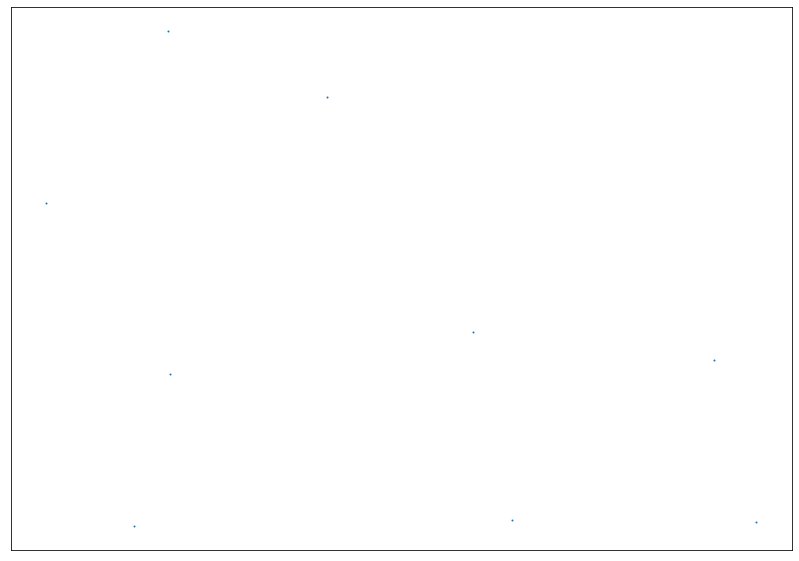

In [11]:
ex.plot_simple_umap()

In [10]:
ex.plot_interactive_umap()

In [99]:
ex = UMAP_Maker(dir_path='I05_multiOrganelles_Linked/', mito=True, nuclei=True, cyto=False, subset=range(1, 10), image_size=100)

In [100]:
ex.plot_organelles_as_marching_cubes(2, save=True)

/var/folders/p1/99sndrn56lv71k57w35yh8n40000gn/T/ipykernel_10127/3213118661.py:221: FutureWarning:

marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19



In [77]:
coord = ex.unify_ravel()

In [57]:
# make array

data = []

for label in coord:
    data.append(coord[label])

em_data = np.asarray(data)

In [59]:
embedding = umap.UMAP(n_neighbors=5).fit_transform(em_data)

[]

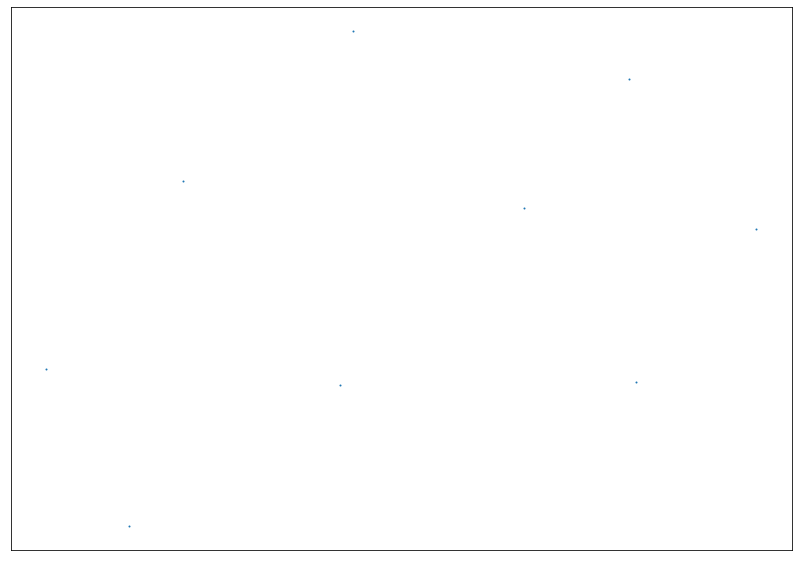

In [60]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=1, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])

In [63]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10

output_notebook()

Loading BokehJS ...

In [64]:
from io import BytesIO
from PIL import Image
import base64

In [ ]:
def embeddable_image(data):
    img_data = 255 - 15 * data.astype(np.uint8)
    image = Image.fromarray(img_data, mode='L').resize((64, 64), Image.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

In [83]:
for label in coord:
    print(label)
    

4
4
3
3
2
2
5
5
7
7
8
8
6
6
9
9
1
1


In [102]:
dir_path = "3D_images/"
for label in coord:
    num = str(label)
    ex.plot_organelles_as_marching_cubes(label, save=True)
    image = Image.open(dir_path+num+".png")
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    
    #return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

4


/var/folders/p1/99sndrn56lv71k57w35yh8n40000gn/T/ipykernel_10127/3213118661.py:221: FutureWarning:

marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19



4
done
3
3
done
2
2
done
5
5
done
7
7
done
8
8
done
6
6
done
9
9
done
1
1
done


In [104]:
def embeddable_image(label):
    image = Image.open("3D_images/"+str(label)+".png")
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

In [105]:
digits_df = pd.DataFrame(embedding, columns=('x', 'y'))
# digits_df['digit'] = [str(x) for x in digits.target]
digits_df['image'] = list(map(embeddable_image, range(1, 10)))

datasource = ColumnDataSource(digits_df)
# color_mapping = CategoricalColorMapper(factors=[str(9 - x) for x in digits.target_names],
                                    #    palette=Spectral10)

plot_figure = figure(
    title='UMAP projection of the Digits dataset',
    plot_width=600,
    plot_height=600,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>Digit:</span>
        <span style='font-size: 18px'>@digit</span>
    </div>
</div>
"""))

plot_figure.circle(
    'x',
    'y',
    source=datasource,
    # color=dict(field='digit', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=4
)
show(plot_figure)